First I want to explore some possibilities with GARCH

In [90]:
import yfinance as yf
import numpy as np

data = yf.Ticker("SPX")

x = data.history(period="10y",interval="1d")
x['daily_log_returns'] = np.log(x['Close']/x['Close'].shift(-1))
x = x.dropna()
#x = np.array(x)
print(x['daily_log_returns'])
x = x['daily_log_returns']

split_index = int(np.round(len(x)/2))
first = x[:split_index]
second = x[split_index:]

mu = x.mean()
print(f"Mean: {mu}")

Date
2015-03-18 00:00:00-04:00    0.000000
2015-03-19 00:00:00-04:00    0.000000
2015-03-20 00:00:00-04:00    0.000000
2015-03-23 00:00:00-04:00   -0.317510
2015-03-24 00:00:00-04:00   -0.167732
                               ...   
2018-01-23 00:00:00-05:00    0.000000
2018-01-24 00:00:00-05:00    0.000000
2018-01-25 00:00:00-05:00    0.095310
2018-01-26 00:00:00-05:00    0.000000
2018-01-29 00:00:00-05:00    0.000000
Name: daily_log_returns, Length: 723, dtype: float64
Mean: -0.002984259165635028


By assuming that daily compounded returns are normally distributed, we can do the following:

Estimate variance using sample variance formula:

$$S^{2} = \frac{1}{n-1}\sum_{i=1}^{n}(X_{i} - \bar{X})^{2}$$

Then the random variable $$\frac{(n-1)S^{2}}{\sigma^2}~\chi^{2}_{n-1}$$
is chi squared distributed with n-1 degrees of freedom

In [91]:
import numpy as np
from scipy.stats import f

mid = len(x) // 2
x1, x2 = x[:mid], x[mid:]

s1_sq = np.var(x1, ddof=1)  # Sample variance for first half
s2_sq = np.var(x2, ddof=1)  # Sample variance for second half

# Compute F-statistic
F_stat = s1_sq / s2_sq

# Degrees of freedom
df1 = len(x1) - 1
df2 = len(x2) - 1

# Compute p-value (two-tailed test)
p_value = 2 * min(f.cdf(F_stat, df1, df2), 1 - f.cdf(F_stat, df1, df2))

# Return results
s1_sq, s2_sq, F_stat, p_value
print(p_value)

1.0930576757102379e-10


In [92]:
import numpy as np
import pandas as pd
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

returns = x 

p_values = range(0, 4) 
q_values = range(0, 4)

model_results = []

for p, q in itertools.product(p_values, q_values):
    try:
        model = ARIMA(returns, order=(p, 0, q)).fit()
        
        # Store results
        model_results.append({
            'p': p,
            'q': q,
            'AIC': model.aic,
            'BIC': model.bic
        })
    
    except Exception as e:
        print(f"Model (p={p}, q={q}) failed: {e}")

results_df = pd.DataFrame(model_results)

best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

# Print results
print("Best model based on AIC:")
print(best_aic_model)

print("\nBest model based on BIC:")
print(best_bic_model)


Best model based on AIC:
p         1.000000
q         2.000000
AIC    1444.210569
BIC    1467.127615
Name: 6, dtype: float64

Best model based on BIC:
p         0.000000
q         1.000000
AIC    1446.813387
BIC    1460.563614
Name: 1, dtype: float64


Findings: ARMA model of order (0,0) is best accoridng to both information criteria.

As a result, our mean equation that we will use for GARCH is simply:

$$r_{t} = \mu + a_{t}$$

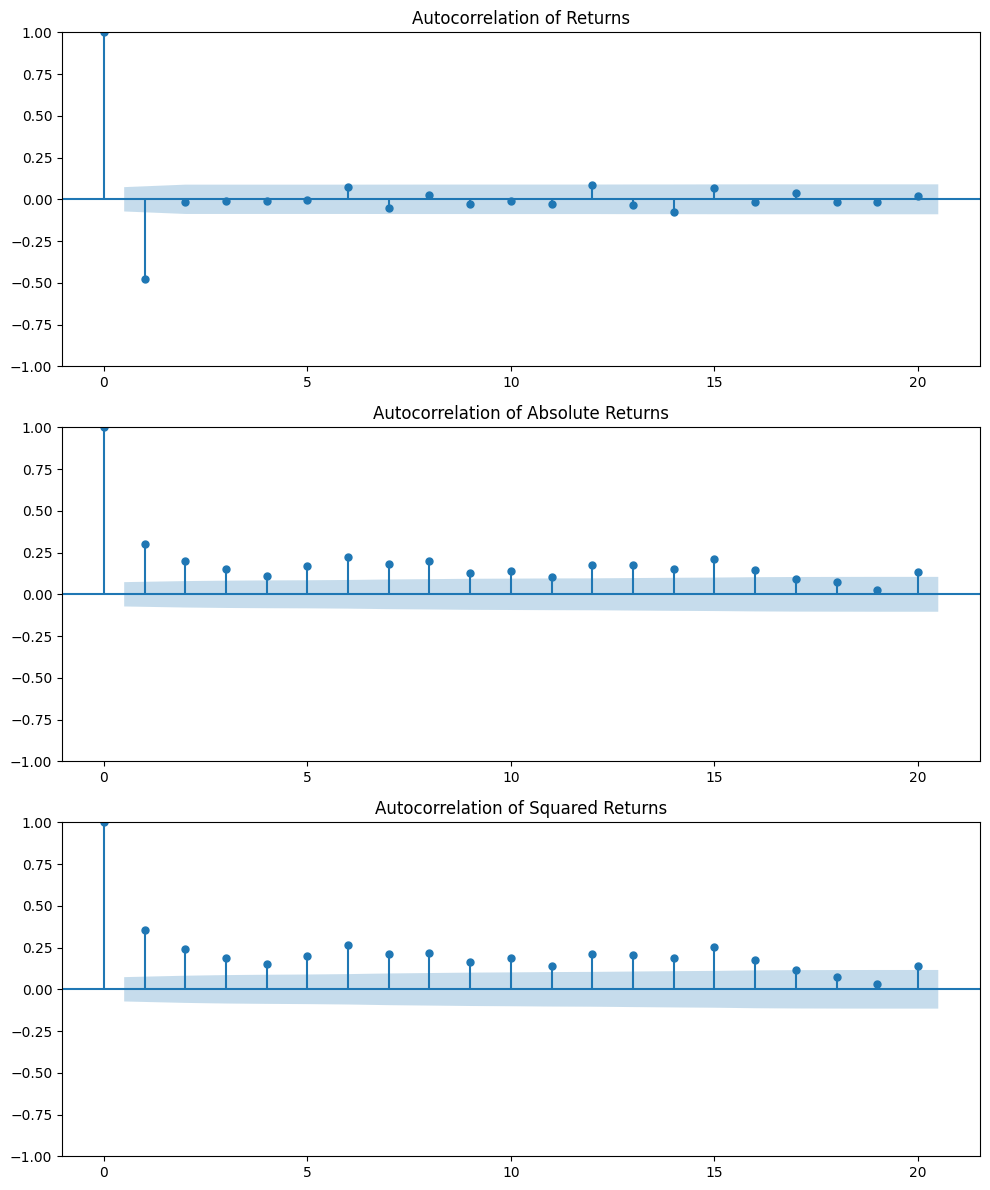

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

num_lags = 20

np.random.seed(42)
returns = x

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

sm.graphics.tsa.plot_acf(returns, lags=num_lags, ax=axes[0])
axes[0].set_title("Autocorrelation of Returns")

sm.graphics.tsa.plot_acf(np.abs(returns), lags=num_lags, ax=axes[1])
axes[1].set_title("Autocorrelation of Absolute Returns")

sm.graphics.tsa.plot_acf(returns**2, lags=num_lags, ax=axes[2])
axes[2].set_title("Autocorrelation of Squared Returns")

plt.tight_layout()
plt.show()


In [94]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch

returns = x 

arma_model = ARIMA(returns, order=(0,0,1)).fit()

residuals = arma_model.resid

lm_test = het_arch(residuals, )

LM_stat = lm_test[0] 
LM_pvalue = lm_test[1] 

print(f"ARCH-LM Test Statistic: {LM_stat:.4f}")
print(f"p-value: {LM_pvalue:.4f}")

if LM_pvalue < 0.05:
    print("Significant ARCH effects detected (p < 0.05). GARCH modeling is recommended.")
else:
    print("No significant ARCH effects detected (p >= 0.05). GARCH may not be necessary.")


ARCH-LM Test Statistic: 175.5991
p-value: 0.0000
Significant ARCH effects detected (p < 0.05). GARCH modeling is recommended.


We have found that there are singificant ARCH effects, so we model a GARCH model.

In [95]:
import numpy as np
import pandas as pd
from arch import arch_model

returns = x  
p_values = range(1, 4)  # GARCH terms (lags of variance)
q_values = range(1, 4)  # ARCH terms (lags of squared residuals)

model_results = []

initial_variance = np.var(returns, ddof=1)

for p in p_values:
    for q in q_values:
        try:
            model = arch_model(returns, vol='Garch', p=p, q=q, mean='Constant')
            fitted_model = model.fit(disp="off")
            model_results.append({
                'p': p,
                'q': q,
                'AIC': fitted_model.aic,
                'BIC': fitted_model.bic,
                'Log-Likelihood': fitted_model.loglikelihood,
                'model': fitted_model
            })

        except Exception as e:
            print(f"GARCH({p},{q}) failed: {e}")

results_df = pd.DataFrame(model_results)

best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

print("Best model based on AIC:")
print(best_aic_model)

print("\nBest model based on BIC:")
print(best_bic_model)

print(best_bic_model['model'])


Best model based on AIC:
p                                                                 1
q                                                                 3
AIC                                                     1356.791611
BIC                                                     1384.292067
Log-Likelihood                                          -672.395806
model                                  Constant Mean - GARCH Mod...
Name: 2, dtype: object

Best model based on BIC:
p                                                                 1
q                                                                 1
AIC                                                     1363.197253
BIC                                                      1381.53089
Log-Likelihood                                          -677.598627
model                                  Constant Mean - GARCH Mod...
Name: 0, dtype: object
                     Constant Mean - GARCH Model Results                      
Dep. Var

If a GARHC(x,y) model fitted on two differnet periods have different parameters, it means that the way volatility respond to shocks and to previous levels of volatility is different.


We create the same model on two periods.

Then we create the same model on the entire period.

Then we use LR test, which basically use a restricted model and unrestricted model. 


## LR test

relies on the log likelihood values. The likelihood values represent a value from the model that tell us how well the model fitted its parameters onto the observed data, under the assumption of a specific probability distribution. 

MLE maximize the function, but is not necessarily any good. The value we get from the log likelihood function will tell us something about how good it was. 

LR = -2 * (log L_restricted - (log L_before + log L_after))

The core is to see whether splitting up the data IMPROVES the model or not. 

The reason why log L before + log L after is approximately equal to log L restricted IF there is NO change is becasue of the log property. log L1 + logL2 = log(L1*L2). this means that the probability function (joint prob, or likelihood ufnction) of the restricted regression would be structurally equal to the sum of the two smaller samples. Because of this, if the ratio signifcantly differnet from 0, we have a case of changed distribution.

The LR statistic is chi squared with degrees of freedom equal to the number of parameters.

In [97]:
import numpy as np
import pandas as pd
from arch import arch_model
from scipy.stats import chi2

returns_before = first
returns_after = second

#These are considered unrestricted because they are less strict than the other one
model_before = arch_model(returns_before, vol='Garch', p=1, q=1, mean='Constant').fit(disp="off")
model_after = arch_model(returns_after, vol='Garch', p=1, q=1, mean='Constant').fit(disp="off")

#This is called restricted because it force the relationship to apply for the entire period
model_restricted = arch_model(returns, vol='Garch', p=1, q=1, mean='Constant').fit(disp="off")

LR_stat = -2 * (model_restricted.loglikelihood - (model_before.loglikelihood + model_after.loglikelihood))
df = 3  # Degrees of freedom (3 parameters: omega, alpha, beta)
p_value = 1 - chi2.cdf(LR_stat, df)

print(f"Likelihood Ratio Test Statistic: {LR_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant difference in GARCH parameters (reject H0).")
else:
    print("No significant difference in GARCH parameters (fail to reject H0).")

print("\n")

print(model_before)
print(f"\n*********\n")
print(model_after)

Likelihood Ratio Test Statistic: 9.6546
P-value: 0.0217
Significant difference in GARCH parameters (reject H0).


                     Constant Mean - GARCH Model Results                      
Dep. Variable:      daily_log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -240.506
Distribution:                  Normal   AIC:                           489.012
Method:            Maximum Likelihood   BIC:                           504.579
                                        No. Observations:                  362
Date:                Mon, Mar 17 2025   Df Residuals:                      361
Time:                        23:40:28   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------

In this very specific instance, omega increased, alpha increased, but beta decreased.

Omega is the constant mean level. This indicates that the overall volatility increased in the second period. 

Alpha is the ARCH parameter, the shock term. An increase here indicates that the market reacts more to shocks in the second period. 

Beta is the GARCH parameter, which is the past level of variance. A decrease here indicates that the market care less about previous levels of volatility.


Overall, I suppose this indicates that the second period is at a higher level of risk in general, and place greater emphasis on reacting to certain news and events and other influences rather than relying on the past level of voaltility only. It is worht noting that while beta decreased, it is still extremely significant statistically with a p-value of 9.19e-45. However it fell by almost 19% (from 0.89 to 0.72). This is a change. 